In [39]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [40]:
prototxtPath = 'drive/My Drive/BE Project/Models/deploy.prototxt'
weightsPath = 'drive/My Drive/BE Project/Models/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [41]:
model = load_model('drive/My Drive/BE Project/Models/')

In [54]:
# Read an image
image = cv2.imread('not.png')
orig = image.copy()
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

In [55]:
net.setInput(blob)
detections = net.forward()

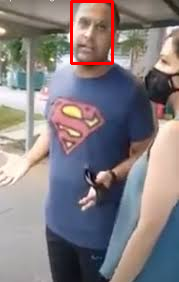

-1

In [59]:
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)